We implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims,self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Calculate the forward pass. Use Proper non-linear activation function between the linear layers
        x=F.relu(self.fc1(state))
        x=F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

In [ ]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.2, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        # Create an instance of te Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)


    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1


    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
          state= T.Tensor([observation]).to(self.Q_eval.device)
          Q_val= self.Q_eval.forward(state)
          action= T.argmax(Q_val).item()
        else:
          action= np.random.choice(self.action_space)

        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        batch = np.random.choice(min(self.mem_cntr,self.mem_size),self.batch_size,replace=False )

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        # Current state Q-value as predicted by the network
        # Note to filter the matrix to only q-values corresponding to our "action_batch"
        batch_i=np.arange(self.batch_size,dtype=np.int32)
        q_eval = self.Q_eval.forward(state_batch)[batch_i,action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch]=0.0

        # The target Q-value of our current state with a discount factor of gamma
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        # Make the network learn this target Q-value via a proper definitio of loss function
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor it possible
        if self.epsilon > self.eps_min:
          self.epsilon = self.epsilon - self.eps_dec
        else:
          self.epsilon =self.eps_min

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/maze.py /content/maze.py

Mounted at /content/drive


In [ ]:
from maze import MazeEnvironment
import warnings
warnings.filterwarnings('ignore')

# Create a maze environment
# You can create a new one or use the files stored in directory mazes to load a maze
env = MazeEnvironment()

In [ ]:
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=30, n_actions=4, eps_end=0.2, input_dims=[2], lr=0.001)
scores = []
n_games = 60

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    counter = 0
    while not done:
        counter += 1
        # If performed 1000 moves and didn't finish the maze, reset the environment
        if (counter == 1000):
            #counter = 0
            #score = 0
            observation = env.reset()
            break

        # Make the agent choose an action
        action = agent.choose_action(observation)

        # Retrieve the reward and next_state from the envirinment
        observation_, reward, done = env.step(action)

        score += reward

        # Store the current episode in the memory
        agent.store_transition(observation, action, reward, observation_, done)  #??!!

        # Learn the current episode
        agent.learn()

        # Change the next state to the current state
        observation = observation_

    scores.append(score)

    avg_score = np.mean(scores[-100:])

    print('episode ', i+1, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

episode  1 score 6236.00 average score 6236.00 epsilon 0.52
episode  2 score 7171.00 average score 6703.50 epsilon 0.20
episode  3 score 2886.00 average score 5431.00 epsilon 0.20
episode  4 score 5422.00 average score 5428.75 epsilon 0.20
episode  5 score 6711.00 average score 5685.20 epsilon 0.20
episode  6 score 9286.00 average score 6285.33 epsilon 0.20
episode  7 score 11779.00 average score 7070.14 epsilon 0.20
episode  8 score 11643.00 average score 7641.75 epsilon 0.20
episode  9 score 19077.00 average score 8912.33 epsilon 0.20
episode  10 score 8540.00 average score 8875.10 epsilon 0.20
episode  11 score 20912.00 average score 9969.36 epsilon 0.20
episode  12 score 19843.00 average score 10792.17 epsilon 0.20
episode  13 score 21456.00 average score 11612.46 epsilon 0.20
episode  14 score 22698.00 average score 12404.29 epsilon 0.20
episode  15 score 18899.00 average score 12837.27 epsilon 0.20
episode  16 score 21922.00 average score 13405.06 epsilon 0.20
episode  17 score 2

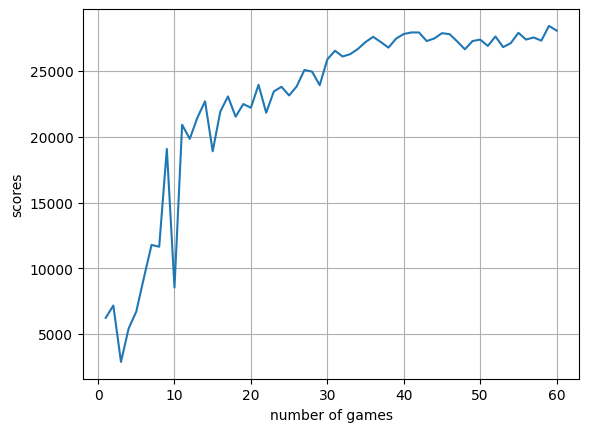

In [ ]:
x=[i+1 for i in range(n_games)]
plt.plot(x,scores)
plt.ylabel('scores') ; plt.xlabel('number of games'); plt.grid()

**parameters:**\
batch_size=30 (Initially, I set the batch size to 10, but the score changes were too abrupt and somewhat stochastic. Therefore, I increased the batch size to make the changes smoother)\
epsilon=1 ; epsilon decay= $0.5*10^{-3}$ ; epsilon end=0.2 ;\
gamma=0.99 ; learning rate(lr)=$10^{-3}$ & number of games=60\
As we can see in the plot above, after approximately 35 iterations of playing the game, the agent will achieve a high score(25000).

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.